In [1]:
from pprint import pprint
from collections import Counter

import pandas as pd
import numpy as np
import scipy

from natsort import natsorted
import itertools

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedKFold, StratifiedShuffleSplit
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from ml_metrics import auc

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df_train = pd.read_csv('../input/train2016.csv')
df_test = pd.read_csv('../input/test2016.csv')

party_encoder = LabelEncoder()
df_train.Party = party_encoder.fit_transform(df_train.Party)

TRAIN = 0
HOLD_OUT = 1
TEST = 2

df_train['source'] = TRAIN
cv = StratifiedShuffleSplit(df_train.Party, n_iter=1, test_size=500, random_state=31)
_, holdout_idx = next(iter(cv))
df_train.loc[holdout_idx, 'source'] = HOLD_OUT
df_test['source'] = TEST

df_all = pd.concat([df_train, df_test]).reset_index(drop=1)

describe = df_all.YOB.describe(percentiles=[0.01, 0.99])
low = describe['1%']
high = describe['99%']

df_all.loc[(df_all.YOB < low) | (df_all.YOB > high), 'YOB'] = np.nan 

# age brackets: below 20 - 20-29 - 30-39 - 40-49 - 50-59 - 60+
age = 2016 - df_all.YOB

bins = [0, 19, 29, 39, 49, 59, 100]
labels = [('%d-%d') % (bins[i], bins[i + 1]) for i in range(len(bins) - 1)]
df_all['Age'] = pd.cut(age, bins=bins, labels=labels).astype(str)
df_all.drop('YOB', axis=1, inplace=1)

In [5]:
all_columns  = natsorted(set(df_all.columns) - {'USER_ID', 'Party', 'source'})
questions    = [q for q in all_columns if q.startswith('Q')]
demographics = ['Age', 'EducationLevel', 'Gender', 'HouseholdStatus', 'Income']

In [6]:
for c in all_columns:
    df_all[c] = df_all[c].str.lower()

def clean_level_names(s):
    if isinstance(s, float):
        return s
    s = s.replace('$', '')
    s = s.replace(',', '')
    s = s.replace(' - ', '_')
    s = s.replace(' ', '_')
    return s

df_all.Income = df_all.Income.apply(clean_level_names)
df_all.HouseholdStatus = df_all.HouseholdStatus.str.replace(' ', '_')
df_all.EducationLevel = df_all.EducationLevel.str.replace(' ', '_')

df_all.Q117193 = df_all.Q117193.str.replace(' ', '_')
df_all.Q120194 = df_all.Q120194.str.replace(' ', '_')

df_all.Q98059  = df_all.Q98059.map({'yes': 'yes', 'only-child': 'no'})
df_all.Q99982  = df_all.Q99982.map({'check!': 'yes', 'nope': 'no'})
df_all.Q106997 = df_all.Q106997.map({'yay people!': 'yes', 'grrr people': 'no'})
df_all.Q108855 = df_all.Q108855.map({'yes!': 'yes', 'umm...': 'no'})
df_all.Q117186 = df_all.Q117186.map({'hot headed': 'yes', 'cool headed': 'no'})

In [7]:
df_all.loc[:, all_columns] = df_all.loc[:, all_columns].fillna('NA')

In [8]:
df_questions = pd.read_csv('questions_selected.csv', index_col='Question ID')
yes_no = set(df_questions[df_questions['Possible Answers'] == 'Yes,No'].index) 
yes_no = natsorted(yes_no | {'Q98059', 'Q99982', 'Q106997', 'Q108855', 'Q117186'})

In [9]:
df_train = df_all[df_all.source == TRAIN]
df_holdout = df_all[df_all.source == HOLD_OUT]
df_test = df_all[df_all.source == TEST]

In [10]:
best_questions = ["Q109244", "Q115611", "Q98197", "Q113181", "Q98869", "Q99480", "Q116881", "Q106272", "Q115195"]
top = demographics + best_questions

In [11]:
records = df_all[top].to_dict(orient='records')
oh_vectorizer = DictVectorizer(separator='_',)
oh_top = oh_vectorizer.fit_transform(records)

svd_top_5 = TruncatedSVD(n_components=5, random_state=1).fit_transform(oh_top)
svd_top_10 = TruncatedSVD(n_components=10, random_state=1).fit_transform(oh_top)
svd_top_15 = TruncatedSVD(n_components=15, random_state=1).fit_transform(oh_top)
nmf_top_5 = NMF(n_components=5, random_state=1).fit_transform(oh_top)
nmf_top_10 = NMF(n_components=10, random_state=1).fit_transform(oh_top)
nmf_top_15 = NMF(n_components=15, random_state=1).fit_transform(oh_top)

In [12]:
not_selected = natsorted(set(all_columns) - set(top))
records = df_all[not_selected].to_dict(orient='records')
oh_vectorizer = DictVectorizer(separator='_',)
oh_not_selected = oh_vectorizer.fit_transform(records)

svd_not_selected_10 = TruncatedSVD(n_components=10, random_state=1).fit_transform(oh_not_selected)
nmf_not_selected_10 = NMF(n_components=10, random_state=1).fit_transform(oh_not_selected)

In [13]:
records = df_all[all_columns].to_dict(orient='records')
oh_vectorizer = DictVectorizer(separator='_',)
oh_all = oh_vectorizer.fit_transform(records)

svd_all_15 = TruncatedSVD(n_components=15, random_state=1).fit_transform(oh_all)
svd_all_25 = TruncatedSVD(n_components=25, random_state=1).fit_transform(oh_all)
svd_all_50 = TruncatedSVD(n_components=50, random_state=1).fit_transform(oh_all)
nmf_all_15 = NMF(n_components=15, random_state=1).fit_transform(oh_all)
nmf_all_25 = NMF(n_components=25, random_state=1).fit_transform(oh_all)
nmf_all_50 = NMF(n_components=50, random_state=1).fit_transform(oh_all)

In [14]:
datasets = {
    'oh_top': oh_top.toarray(),
    'svd_top_5': svd_top_5,
    'svd_top_10': svd_top_10,
    'svd_top_15': svd_top_15,
    'nmf_top_5': nmf_top_5,
    'nmf_top_10': nmf_top_10,
    'nmf_top_15': nmf_top_15,
    'oh_top_notsel_svd': np.hstack([oh_top.toarray(), svd_not_selected_10]),  
    'svd_top_5_notsel_svd': np.hstack([svd_top_5, svd_not_selected_10]),
    'svd_top_10_notsel_svd': np.hstack([svd_top_10, svd_not_selected_10]),
    'svd_top_15_notsel_svd': np.hstack([svd_top_15, svd_not_selected_10]),
    'nmf_top_5_notsel_svd': np.hstack([nmf_top_5, svd_not_selected_10]),
    'nmf_top_10_notsel_svd': np.hstack([nmf_top_10, svd_not_selected_10]),
    'nmf_top_15_notsel_svd': np.hstack([nmf_top_15, svd_not_selected_10]),
    'oh_top_notsel_nmf': np.hstack([oh_top.toarray(), nmf_not_selected_10]),
    'svd_top_5_notsel_nmf': np.hstack([svd_top_5, nmf_not_selected_10]),
    'svd_top_10_notsel_nmf': np.hstack([svd_top_10, nmf_not_selected_10]),
    'svd_top_15_notsel_nmf': np.hstack([svd_top_15, nmf_not_selected_10]),
    'nmf_top_5_notsel_nmf': np.hstack([nmf_top_5, nmf_not_selected_10]),
    'nmf_top_10_notsel_nmf': np.hstack([nmf_top_10, nmf_not_selected_10]),
    'nmf_top_15_notsel_nmf': np.hstack([nmf_top_15, nmf_not_selected_10]),
    'oh_all': oh_all.toarray(),
    'svd_all_15': svd_all_15,
    'svd_all_25': svd_all_25,
    'svd_all_50': svd_all_50,
    'nmf_all_15': nmf_all_15,
    'nmf_all_25': nmf_all_25,
    'nmf_all_50': nmf_all_50,
}

In [15]:
from bayes_opt import BayesianOptimization

def round_to_int(val_min, val_max):
    return ('transform', int, (val_min, val_max))

def find_best_params(X, y, model, evaluation_callback, search_space, bo_rounds=20, verbose=0):
    cv = StratifiedKFold(y, n_folds=3, shuffle=True, random_state=1)

    search_space_internal = {}
    to_transform = {}
    for k, v in search_space.items():
        if v[0] == 'transform':
            search_space_internal[k] = v[2]
            to_transform[k] = v[1]
        else:
            search_space_internal[k] = v
    
    def transform_params(params):
        result = {}
        for k, v in params.items():
            if k in to_transform:
                f = to_transform[k]
                result[k] = f(v)
            else:
                result[k] = v
        return result
    
    def optimize(**params):
        scores = []
        params = transform_params(params)
        model.set_params(**params)
        for train, test in cv:
            model.fit(X[train], y[train])
            score = evaluation_callback(model, X[test], y[test])
            scores.append(score)

        return np.mean(scores)

    bo = BayesianOptimization(optimize, search_space_internal, verbose=verbose)
    bo.maximize(n_iter=bo_rounds)

    best_params = bo.res['max']['max_params']
    best_score = bo.res['max']['max_val']

    return transform_params(best_params), best_score

In [16]:
train_idx = df_all.source == TRAIN
ho_idx = df_all.source == HOLD_OUT

y = df_all[train_idx].Party.astype(int).values
y_val = df_all[ho_idx].Party.astype(int).values

In [17]:
def svm_eval(svm, X_val, y_val):
    pred = svm.decision_function(X_val)
    pred = 1 / (1 + np.exp(-pred))
    return auc(y_val, pred)

svm_models = []

for ds_name, dataset in datasets.items():
    X = dataset[train_idx.values]
    X_val = dataset[ho_idx.values]
    svm = LinearSVC()
    svm_search_space = {'C': (0.00005, 1)}

    best_params, best_score = find_best_params(X, y, svm, svm_eval, svm_search_space, bo_rounds=10)
    svm.set_params(**best_params)
    svm.fit(X, y)

    y_pred = svm.predict(X_val).astype(int)
    acc = (y_val == y_pred).mean()

    svm_models.append((ds_name, best_params, svm, acc))
    print ds_name, acc

nmf_top_15_notsel_nmf 0.638
nmf_top_5_notsel_nmf 0.604
svd_top_5_notsel_nmf 0.614
mtv 0.628
svd_top_15_notsel_svd 0.622
alternative 0.642
oh_top_notsel_svd 0.628
oh_top_notsel_nmf 0.626
nmf_top_5 0.604
svd_top_10_notsel_svd 0.646
svd_all_50 0.632
svd_all_15 0.592
svd_top_10 0.636
svd_top_15 0.632
svd_top_5_notsel_svd 0.618
nmf_top_10_notsel_nmf 0.616
svd_top_15_notsel_nmf 0.63
svd_top_5 0.6
oh_all 0.62
nmf_top_15_notsel_svd 0.642
nmf_top_5_notsel_svd 0.608
svd_top_10_notsel_nmf 0.634
nmf_all_50 0.624
svd_all_25 0.614
nmf_top_15 0.634
nmf_top_10_notsel_svd 0.614
nmf_all_15 0.554
nmf_top_10 0.6
nmf_all_25 0.572
oh_top 0.63


In [18]:
def sklearn_standard_eval(m, X_val, y_val):
    pred = m.predict_proba(X_val)[:, 1]
    return auc(y_val, pred)

svm_rbf_models = []

for ds_name, dataset in datasets.items():
    X = dataset[train_idx.values]
    X_val = dataset[ho_idx.values]
    svm = SVC(kernel='rbf', probability=True)
    svm_search_space = {'C': (0.00005, 2)}

    best_params, best_score = find_best_params(X, y, svm, sklearn_standard_eval, svm_search_space, bo_rounds=7)
    svm.set_params(**best_params)
    svm.fit(X, y)

    y_pred = svm.predict(X_val).astype(int)
    acc = (y_val == y_pred).mean()

    svm_rbf_models.append((ds_name, best_params, svm, acc))
    print ds_name, acc

nmf_top_15_notsel_nmf 0.604
nmf_top_5_notsel_nmf 0.58
svd_top_5_notsel_nmf 0.614
mtv 0.638
svd_top_15_notsel_svd 0.642
alternative 0.638
oh_top_notsel_svd 0.636
oh_top_notsel_nmf 0.638
nmf_top_5 0.586
svd_top_10_notsel_svd 0.62
svd_all_50 0.61
svd_all_15 0.566
svd_top_10 0.608
svd_top_15 0.63
svd_top_5_notsel_svd 0.598
nmf_top_10_notsel_nmf 0.598
svd_top_15_notsel_nmf 0.63
svd_top_5 0.612
oh_all 0.608
nmf_top_15_notsel_svd 0.56
nmf_top_5_notsel_svd 0.548
svd_top_10_notsel_nmf 0.608
nmf_all_50 0.53
svd_all_25 0.606
nmf_top_15 0.614
nmf_top_10_notsel_svd 0.56
nmf_all_15 0.556
nmf_top_10 0.582
nmf_all_25 0.598
oh_top 0.634


In [19]:
params_set = {
    'svm_params': svm_models,
    'svm_rbf_params': svm_rbf_models,
}

for dict_name, models in params_set.items():
    print dict_name, '= {'
    for ds_name, best_params, model, acc in models:
        print "    '%s': %s, # %0.3f" % (ds_name, best_params, acc)
    print '}'
    print

svm_params = {
    'nmf_top_15_notsel_nmf': {'C': 0.69321305571720226}, # 0.638
    'nmf_top_5_notsel_nmf': {'C': 0.91349932602059136}, # 0.604
    'svd_top_5_notsel_nmf': {'C': 0.15167154118755863}, # 0.614
    'mtv': {'C': 0.023722913966058645}, # 0.628
    'svd_top_15_notsel_svd': {'C': 0.098033592004883971}, # 0.622
    'alternative': {'C': 0.42890651105294347}, # 0.642
    'oh_top_notsel_svd': {'C': 0.023837630761856292}, # 0.628
    'oh_top_notsel_nmf': {'C': 0.071723987188209382}, # 0.626
    'nmf_top_5': {'C': 1.0}, # 0.604
    'svd_top_10_notsel_svd': {'C': 0.07645076102888701}, # 0.646
    'svd_all_50': {'C': 0.97924085163206098}, # 0.632
    'svd_all_15': {'C': 0.19273835898510619}, # 0.592
    'svd_top_10': {'C': 0.33907125526716581}, # 0.636
    'svd_top_15': {'C': 0.93863689565760577}, # 0.632
    'svd_top_5_notsel_svd': {'C': 0.052262222410459122}, # 0.618
    'nmf_top_10_notsel_nmf': {'C': 0.60419796734036824}, # 0.616
    'svd_top_15_notsel_nmf': {'C': 0.07384752257656

In [21]:
svm_params = {
    'nmf_top_15_notsel_nmf': {'C': 0.69321305571720226}, # 0.638
    'nmf_top_5_notsel_nmf': {'C': 0.91349932602059136}, # 0.604
    'svd_top_5_notsel_nmf': {'C': 0.15167154118755863}, # 0.614
    'svd_top_15_notsel_svd': {'C': 0.098033592004883971}, # 0.622
    'oh_top_notsel_svd': {'C': 0.023837630761856292}, # 0.628
    'oh_top_notsel_nmf': {'C': 0.071723987188209382}, # 0.626
    'nmf_top_5': {'C': 1.0}, # 0.604
    'svd_top_10_notsel_svd': {'C': 0.07645076102888701}, # 0.646
    'svd_all_50': {'C': 0.97924085163206098}, # 0.632
    'svd_all_15': {'C': 0.19273835898510619}, # 0.592
    'svd_top_10': {'C': 0.33907125526716581}, # 0.636
    'svd_top_15': {'C': 0.93863689565760577}, # 0.632
    'svd_top_5_notsel_svd': {'C': 0.052262222410459122}, # 0.618
    'nmf_top_10_notsel_nmf': {'C': 0.60419796734036824}, # 0.616
    'svd_top_15_notsel_nmf': {'C': 0.073847522576564878}, # 0.630
    'svd_top_5': {'C': 0.02085284132838814}, # 0.600
    'oh_all': {'C': 0.0026402810121232624}, # 0.620
    'nmf_top_15_notsel_svd': {'C': 0.97759048052356123}, # 0.642
    'nmf_top_5_notsel_svd': {'C': 0.95225048665533629}, # 0.608
    'svd_top_10_notsel_nmf': {'C': 0.15231137972577216}, # 0.634
    'nmf_all_50': {'C': 0.99903529644260691}, # 0.624
    'svd_all_25': {'C': 0.45011573705300428}, # 0.614
    'nmf_top_15': {'C': 0.40958024992915704}, # 0.634
    'nmf_top_10_notsel_svd': {'C': 0.80744274390613024}, # 0.614
    'nmf_all_15': {'C': 0.17314403233766912}, # 0.554
    'nmf_top_10': {'C': 0.9143573939562053}, # 0.600
    'nmf_all_25': {'C': 1.0}, # 0.572
    'oh_top': {'C': 0.21049266255578908}, # 0.630
}

svm_rbf_params = {
    'nmf_top_15_notsel_nmf': {'C': 2.0}, # 0.604
    'nmf_top_5_notsel_nmf': {'C': 2.0}, # 0.580
    'svd_top_5_notsel_nmf': {'C': 2.0}, # 0.614
    'svd_top_15_notsel_svd': {'C': 0.99463539553853331}, # 0.642
    'oh_top_notsel_svd': {'C': 0.99292456077965718}, # 0.636
    'oh_top_notsel_nmf': {'C': 2.0}, # 0.638
    'nmf_top_5': {'C': 2.0}, # 0.586
    'svd_top_10_notsel_svd': {'C': 0.54599603497527593}, # 0.620
    'svd_all_50': {'C': 0.75931063513043806}, # 0.610
    'svd_all_15': {'C': 0.62908704507633795}, # 0.566
    'svd_top_10': {'C': 0.4299317488628388}, # 0.608
    'svd_top_15': {'C': 0.84106683216597722}, # 0.630
    'svd_top_5_notsel_svd': {'C': 0.64276277266668769}, # 0.598
    'nmf_top_10_notsel_nmf': {'C': 2.0}, # 0.598
    'svd_top_15_notsel_nmf': {'C': 1.4769677050229639}, # 0.630
    'svd_top_5': {'C': 1.7310963933072609}, # 0.612
    'oh_all': {'C': 0.94743922501636857}, # 0.608
    'nmf_top_15_notsel_svd': {'C': 2.0}, # 0.560
    'nmf_top_5_notsel_svd': {'C': 2.0}, # 0.548
    'svd_top_10_notsel_nmf': {'C': 1.5588057695061843}, # 0.608
    'nmf_all_50': {'C': 1.0983406391792048}, # 0.530
    'svd_all_25': {'C': 0.62237267586232325}, # 0.606
    'nmf_top_15': {'C': 2.0}, # 0.614
    'nmf_top_10_notsel_svd': {'C': 2.0}, # 0.560
    'nmf_all_15': {'C': 2.0}, # 0.556
    'nmf_top_10': {'C': 2.0}, # 0.582
    'nmf_all_25': {'C': 2.0}, # 0.598
    'oh_top': {'C': 2.0}, # 0.634
}

In [22]:
from heamy.dataset import Dataset
from heamy.estimator import Classifier
from heamy.pipeline import ModelsPipeline

In [23]:
def svm_predict_proba(self, X_test):
    pred = self.decision_function(X_test)
    return 1 / (1 + np.exp(-pred))

LinearSVC.predict_proba = svm_predict_proba

In [24]:
heamy_datasets = {}
for ds_name, dataset in datasets.items():
    X = dataset[train_idx.values]
    X_val = dataset[ho_idx.values]
    heamy_datasets[ds_name] = Dataset(X, y, X_val)

classifiers = []

for ds_name, params in svm_params.items():
    clf = Classifier(dataset=heamy_datasets[ds_name], estimator=LinearSVC, parameters=params,
                     name='svm_lin_' + ds_name)
    classifiers.append(clf)

for ds_name, params in svm_rbf_params.items():
    params = params.copy()
    params['probability'] = True
    clf = Classifier(dataset=heamy_datasets[ds_name], estimator=SVC, parameters=params,
                     name='svm_rbf_' + ds_name)
    classifiers.append(clf)

In [25]:
pipeline = ModelsPipeline(*classifiers)
stacked = pipeline.stack()

In [26]:
corr = stacked.X_train.corr()

no, comps = scipy.sparse.csgraph.connected_components(corr.values >= 0.95)
uncorrelated = pd.DataFrame({'variable': corr.columns, 'component': comps}).groupby('component').head(1).variable
use = natsorted(uncorrelated)

In [27]:
stacked_decorr = Dataset(X_train=stacked.X_train[use], y_train=stacked.y_train, X_test=stacked.X_test[use])
stacker = Classifier(dataset=stacked_decorr, estimator=LogisticRegression)

_ = stacker.validate(k=10, scorer=roc_auc_score)
stacked_result = stacker.predict()
stacked_result.shape

Metric: roc_auc_score
Folds accuracy: [0.68730924945499838, 0.67881955409587569, 0.70593090988381146, 0.64980679212088832, 0.66124964976183809, 0.69852550685701786, 0.68057592113062748, 0.68678438835678401, 0.71548647633358375, 0.7036030341340076]
Mean accuracy: 0.686809148213
Standard Deviation: 0.0193202959281
Variance: 0.00037327383475


(500,)

0.44999999999999996

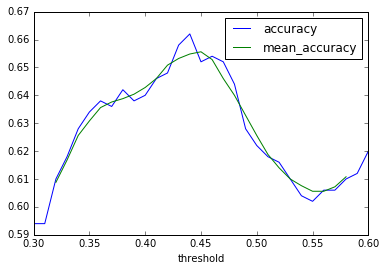

In [28]:
thresholds = []
for i in np.linspace(0.30, 0.60, 31):
    stacked_pred = (stacked_result >= i).astype(int)
    acc = (y_val == stacked_pred).mean()
    thresholds.append((i, acc))

thresholds = pd.DataFrame(thresholds, columns=['threshold', 'accuracy'])
thresholds['mean_accuracy'] = thresholds.accuracy.rolling(5, center=True).mean()
ax = thresholds.plot(kind='line', x='threshold', y='accuracy')
thresholds.plot(kind='line', x='threshold', y='mean_accuracy', ax=ax)

thresholds.threshold[thresholds.mean_accuracy.argmax()]

Submission

In [29]:
full_train_idx = df_all.source != TEST
full_test_idx = df_all.source == TEST
y_full = df_all[full_train_idx].Party.astype(int).values

heamy_datasets_full = {}
for ds_name, dataset in datasets.items():
    X_full = dataset[full_train_idx.values]
    X_test = dataset[full_test_idx.values]
    heamy_datasets_full[ds_name] = Dataset(X_full, y_full, X_test)

classifiers = []

for ds_name, params in svm_params.items():
    clf = Classifier(dataset=heamy_datasets_full[ds_name], estimator=LinearSVC, parameters=params,
                     name='svm_lin_' + ds_name)
    classifiers.append(clf)

for ds_name, params in svm_rbf_params.items():
    params = params.copy()
    params['probability'] = True
    clf = Classifier(dataset=heamy_datasets_full[ds_name], estimator=SVC, parameters=params,
                     name='svm_rbf_' + ds_name)
    classifiers.append(clf)

In [30]:
pipeline = ModelsPipeline(*classifiers)
stacked = pipeline.stack()

In [31]:
stacked_decorr = Dataset(X_train=stacked.X_train[use], y_train=stacked.y_train, X_test=stacked.X_test[use])
stacker = Classifier(dataset=stacked_decorr, estimator=LogisticRegression)
stacked_result = stacker.predict()

In [32]:
y_pred = (stacked_result >= 0.45).astype(int)
y_pred = party_encoder.inverse_transform(y_pred)

user_ids = df_all.USER_ID[df_all.source == TEST].values

result = pd.DataFrame({'USER_ID': user_ids, 'Predictions': y_pred})
result.to_csv('heamy3.csv', index=False)